#**Теплопроводность центральными разностями**

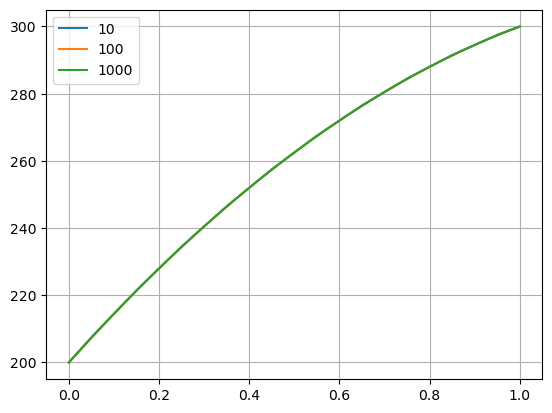

In [1]:
import matplotlib.pyplot as plt
import numpy as np

T_l = 200  # К
T_r = 300  # К
L = 1  # м
llambda = 10  # Вт/м К
sq = 0.1  # м2
q0 = 1000  # Вт/м3

Ns = [10, 100, 1000]
for N in Ns:

    cells_c = [i * L / N + L / N / 2 for i in range(N)]
    cells_b = np.array([i * L / N for i in range(N + 1)])
    volumes = [float((cells_b[i + 1] - cells_b[i])) * sq for i in range(N)]
    Tmtx = np.zeros((N, N))
    res = np.array([0. for i in range(N)])

    for i in range(N):
        if i == 0:
            aw = llambda * sq / (cells_c[i] - 0)
            ae = llambda * sq / (cells_c[i + 1] - cells_c[i])
            ap = aw + ae
            Tmtx[i][i] = -ap
            Tmtx[i][i + 1] = ae
            res[i] = -q0 * volumes[i] - aw * T_l

        elif i == N - 1:
            aw = llambda * sq / (cells_c[i] - cells_c[i - 1])
            ae = llambda * sq / (L - cells_c[i])
            ap = aw + ae
            Tmtx[i][i] = -ap
            Tmtx[i][i - 1] = aw
            res[i] = -q0 * volumes[i] - ae * T_r
        else:
            aw = llambda * sq / (cells_c[i] - cells_c[i - 1])
            ae = llambda * sq / (cells_c[i + 1] - cells_c[i])
            ap = aw + ae
            Tmtx[i][i] = -ap
            Tmtx[i][i - 1] = aw
            Tmtx[i][i + 1] = ae
            res[i] = float(-q0 * volumes[i])

    '''if N == 10:
        print(Tmtx)
        print(res)
        print(volumes)'''

    # Tmtx * T = res
    T = np.linalg.solve(Tmtx, res)
    T = [T_l] + list(T) + [T_r]
    xs = [0] + list(cells_c) + [1]
    plt.plot(xs, T)

plt.legend(list(map(str, Ns)))
plt.grid()
plt.show()


#**Теплопроводность с диффузией центральными разностями**

Matrix for N=5:
 [[-15.25   4.75   0.     0.     0.  ]
 [  5.25 -10.     4.75   0.     0.  ]
 [  0.     5.25 -10.     4.75   0.  ]
 [  0.     0.     5.25 -10.     4.75]
 [  0.     0.     0.     5.25 -14.75]]
RHS for N=5:
 [-1070.   -20.   -20.   -20. -1920.]
Число Пекле: 0.50


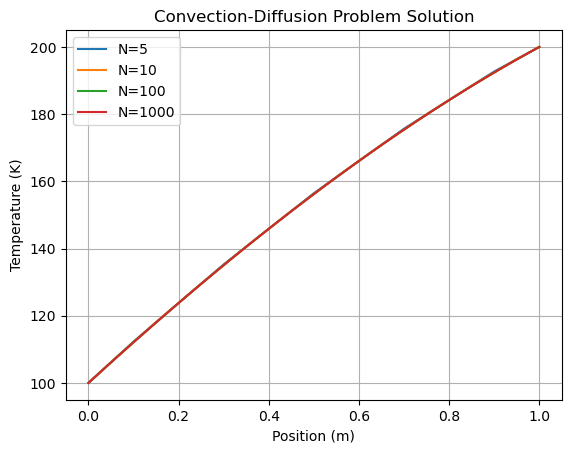

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def solve_convection_diffusion():
    # Parameters
    length = 1.0  # m
    velocity = 0.05  # m/s
    temp_left = 100.0  # K
    temp_right = 200.0  # K
    heat_capacity = 100.0  # J/(kg·K)
    thermal_conductivity = 10.0  # W/(m·K)
    density = 1.0  # kg/m³
    cross_section = 0.1  # m²
    heat_source = 1000.0  # W/m³

    # Grid sizes to test
    grid_sizes = [5, 10, 100, 1000]

    for grid_size in grid_sizes:
        # Cell centers and boundaries
        cell_centers = [i * length / grid_size + length / (2 * grid_size) 
                       for i in range(grid_size)]
        cell_boundaries = np.linspace(0, length, grid_size + 1)
        cell_volumes = [(cell_boundaries[i + 1] - cell_boundaries[i]) * cross_section 
                       for i in range(grid_size)]

        # Initialize matrix and right-hand side
        coefficient_matrix = np.zeros((grid_size, grid_size))
        rhs_vector = np.zeros(grid_size)

        # Calculate convective fluxes
        flux = density * heat_capacity * velocity * cross_section

        for i in range(grid_size):
            if i == 0:  # Left boundary
                coeff_west = thermal_conductivity * cross_section / cell_centers[i]
                coeff_east = (thermal_conductivity * cross_section / 
                             (cell_centers[i + 1] - cell_centers[i]) - flux / 2)
                coeff_main = coeff_west + coeff_east + flux

                coefficient_matrix[i, i] = -coeff_main
                coefficient_matrix[i, i + 1] = coeff_east

                rhs_vector[i] = (-heat_source * cell_volumes[i] - 
                               (coeff_west + flux) * temp_left)

            elif i == grid_size - 1:  # Right boundary
                coeff_west = (thermal_conductivity * cross_section / 
                             (cell_centers[i] - cell_centers[i - 1]) + flux / 2)
                coeff_east = thermal_conductivity * cross_section / (length - cell_centers[i])
                coeff_main = coeff_west + coeff_east - flux

                coefficient_matrix[i, i] = -coeff_main
                coefficient_matrix[i, i - 1] = coeff_west

                rhs_vector[i] = (-heat_source * cell_volumes[i] - 
                               (coeff_east - flux) * temp_right)

            else:  # Internal cells
                coeff_west = (thermal_conductivity * cross_section / 
                             (cell_centers[i] - cell_centers[i - 1]) + flux / 2)
                coeff_east = (thermal_conductivity * cross_section / 
                             (cell_centers[i + 1] - cell_centers[i]) - flux / 2)
                coeff_main = coeff_west + coeff_east + flux - flux  # Fe - Fw = 0

                coefficient_matrix[i, i] = -coeff_main
                coefficient_matrix[i, i + 1] = coeff_east
                coefficient_matrix[i, i - 1] = coeff_west

                rhs_vector[i] = -heat_source * cell_volumes[i]

        if grid_size == 5:
            print(f"Matrix for N={grid_size}:\n", coefficient_matrix)
            print(f"RHS for N={grid_size}:\n", rhs_vector)

        # Solve system
        temperature = np.linalg.solve(coefficient_matrix, rhs_vector)
        full_temperature = [temp_left] + list(temperature) + [temp_right]
        full_grid = [0.0] + cell_centers + [length]

        plt.plot(full_grid, full_temperature, label=f'N={grid_size}')

    # Plot settings
    plt.xlabel('Position (m)')
    plt.ylabel('Temperature (K)')
    plt.title('Convection-Diffusion Problem Solution')
    plt.legend()
    plt.grid()

    # Calculate Peclet number
    peclet_number = density * heat_capacity * velocity * length / thermal_conductivity
    print(f"Число Пекле: {peclet_number:.2f}")

    plt.show()


if __name__ == "__main__":
    solve_convection_diffusion()

#**Теплопроводность с диффузией upwind**

Матрица коэффициентов (N=5):
 [[-15.5   5.    0.    0.    0. ]
 [  5.5 -10.5   5.    0.    0. ]
 [  0.    5.5 -10.5   5.    0. ]
 [  0.    0.    5.5 -10.5   5. ]
 [  0.    0.    0.    5.5 -15.5]]
Вектор правой части (N=5):
 [-1070.   -20.   -20.   -20. -2020.]
Число Пекле: 0.5


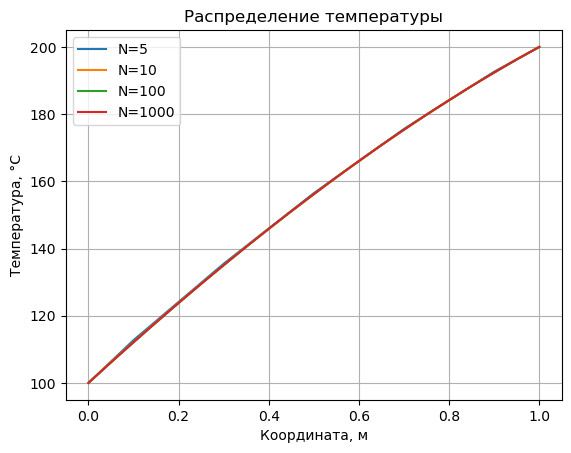

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def solve_heat_transfer_upwind():
    # Параметры задачи
    length = 1.0  # m
    velocity = 0.05  # m/s
    temp_left = 100.0
    temp_right = 200.0
    heat_capacity = 100.0  # Dj / kg / K
    thermal_conductivity = 10.0  # W / m / K
    density = 1.0  # kg / m^3
    cross_section = 0.1  # m^2
    heat_source = 1000.0  # W / m^3

    # Сетки для расчета
    grid_sizes = [5, 10, 100, 1000]

    for grid_size in grid_sizes:
        # Координаты центров ячеек
        cell_centers = [i * length / grid_size + length / grid_size / 2 for i in range(grid_size)]
        # Границы ячеек
        cell_boundaries = np.array([i * length / grid_size for i in range(grid_size + 1)])
        # Объемы ячеек
        cell_volumes = [(cell_boundaries[i + 1] - cell_boundaries[i]) * cross_section for i in range(grid_size)]

        # Матрица коэффициентов и вектор правой части
        coefficient_matrix = np.zeros((grid_size, grid_size))
        rhs_vector = np.zeros(grid_size)

        for i in range(grid_size):
            # Потоки через границы
            flux_east = density * heat_capacity * velocity * cross_section
            flux_west = density * heat_capacity * velocity * cross_section

            if i == 0:  # Левая граница
                coeff_west = (thermal_conductivity * cross_section / (cell_centers[i] - 0) + max(flux_west, 0))
                coeff_east = thermal_conductivity * cross_section / (cell_centers[i + 1] - cell_centers[i]) + max(-flux_east, 0)
                coeff_main = coeff_west + coeff_east + flux_east - flux_west
                source_term = heat_source * cell_volumes[i] + coeff_west * temp_left

                coefficient_matrix[i][i] = -coeff_main
                coefficient_matrix[i][i + 1] = coeff_east

                rhs_vector[i] = -source_term

            elif i == grid_size - 1:  # Правая граница
                coeff_west = thermal_conductivity * cross_section / (cell_centers[i] - cell_centers[i - 1]) + max(flux_west, 0)
                coeff_east = (thermal_conductivity * cross_section / (length - cell_centers[i]) + max(-flux_east, 0))
                coeff_main = coeff_west + coeff_east + flux_east - flux_west
                source_term = heat_source * cell_volumes[i] + coeff_east * temp_right

                coefficient_matrix[i][i] = -coeff_main
                coefficient_matrix[i][i - 1] = coeff_west

                rhs_vector[i] = -source_term

            else:  # Внутренние ячейки
                coeff_west = thermal_conductivity * cross_section / (cell_centers[i] - cell_centers[i - 1]) + max(flux_west, 0)
                coeff_east = thermal_conductivity * cross_section / (cell_centers[i + 1] - cell_centers[i]) + max(-flux_east, 0)
                coeff_main = coeff_west + coeff_east + flux_east - flux_west
                source_term = heat_source * cell_volumes[i]

                coefficient_matrix[i][i] = -coeff_main
                coefficient_matrix[i][i + 1] = coeff_east
                coefficient_matrix[i][i - 1] = coeff_west

                rhs_vector[i] = -source_term

        if grid_size == 5:
            print("Матрица коэффициентов (N=5):\n", coefficient_matrix)
            print("Вектор правой части (N=5):\n", rhs_vector)

        # Решение СЛАУ
        temperature = np.linalg.solve(coefficient_matrix, rhs_vector)
        full_temperature = [temp_left] + list(temperature) + [temp_right]

        # Полная сетка (с границами)
        full_grid = [0.0] + cell_centers + [length]

        plt.plot(full_grid, full_temperature, label=f"N={grid_size}")

    plt.title("Распределение температуры")
    plt.xlabel("Координата, м")
    plt.ylabel("Температура, °C")
    plt.legend()
    plt.grid()

    peclet_number = density * heat_capacity * velocity * length / thermal_conductivity
    print("Число Пекле:", peclet_number)

    plt.show()


if __name__ == "__main__":
    solve_heat_transfer_upwind()


#**Теплопроводность со вторым типом граничных условий**

Матрица коэффициентов (N=5):
 [[-15.5   5.    0.    0.    0. ]
 [  5.5 -10.5   5.    0.    0. ]
 [  0.    5.5 -10.5   5.    0. ]
 [  0.    0.    5.5 -10.5   5. ]
 [  0.    0.    0.    5.5 -15.5]]
Вектор правой части (N=5):
 [-1070.   -20.   -20.   -20. -2020.]
Число Пекле: 0.5


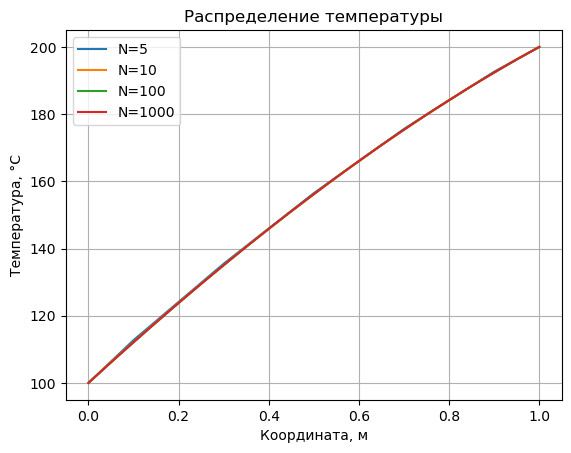

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def solve_heat_transfer_neuman():
    # Параметры задачи
    length = 1.0  # m
    velocity = 0.05  # m/s
    temp_left = 100.0
    temp_right = 200.0
    heat_capacity = 100.0  # Dj / kg / K
    thermal_conductivity = 10.0  # W / m / K
    density = 1.0  # kg / m^3
    cross_section = 0.1  # m^2
    heat_source = 1000.0  # W / m^3

    # Сетки для расчета
    grid_sizes = [5, 10, 100, 1000]

    for grid_size in grid_sizes:
        # Координаты центров ячеек
        cell_centers = [i * length / grid_size + length / grid_size / 2 for i in range(grid_size)]
        # Границы ячеек
        cell_boundaries = np.array([i * length / grid_size for i in range(grid_size + 1)])
        # Объемы ячеек
        cell_volumes = [(cell_boundaries[i + 1] - cell_boundaries[i]) * cross_section for i in range(grid_size)]

        # Матрица коэффициентов и вектор правой части
        coefficient_matrix = np.zeros((grid_size, grid_size))
        rhs_vector = np.zeros(grid_size)

        for i in range(grid_size):
            # Потоки через границы
            flux_east = density * heat_capacity * velocity * cross_section
            flux_west = density * heat_capacity * velocity * cross_section

            if i == 0:  # Левая граница
                coeff_west = (thermal_conductivity * cross_section / (cell_centers[i] - 0) + max(flux_west, 0))
                coeff_east = thermal_conductivity * cross_section / (cell_centers[i + 1] - cell_centers[i]) + max(-flux_east, 0)
                coeff_main = coeff_west + coeff_east + flux_east - flux_west
                source_term = heat_source * cell_volumes[i] + coeff_west * temp_left

                coefficient_matrix[i][i] = -coeff_main
                coefficient_matrix[i][i + 1] = coeff_east

                rhs_vector[i] = -source_term

            elif i == grid_size - 1:  # Правая граница
                coeff_west = thermal_conductivity * cross_section / (cell_centers[i] - cell_centers[i - 1]) + max(flux_west, 0)
                coeff_east = (thermal_conductivity * cross_section / (length - cell_centers[i]) + max(-flux_east, 0))
                coeff_main = coeff_west + coeff_east + flux_east - flux_west
                source_term = heat_source * cell_volumes[i] + coeff_east * temp_right

                coefficient_matrix[i][i] = -coeff_main
                coefficient_matrix[i][i - 1] = coeff_west

                rhs_vector[i] = -source_term

            else:  # Внутренние ячейки
                coeff_west = thermal_conductivity * cross_section / (cell_centers[i] - cell_centers[i - 1]) + max(flux_west, 0)
                coeff_east = thermal_conductivity * cross_section / (cell_centers[i + 1] - cell_centers[i]) + max(-flux_east, 0)
                coeff_main = coeff_west + coeff_east + flux_east - flux_west
                source_term = heat_source * cell_volumes[i]

                coefficient_matrix[i][i] = -coeff_main
                coefficient_matrix[i][i + 1] = coeff_east
                coefficient_matrix[i][i - 1] = coeff_west

                rhs_vector[i] = -source_term

        if grid_size == 5:
            print("Матрица коэффициентов (N=5):\n", coefficient_matrix)
            print("Вектор правой части (N=5):\n", rhs_vector)

        # Решение СЛАУ
        temperature = np.linalg.solve(coefficient_matrix, rhs_vector)
        full_temperature = [temp_left] + list(temperature) + [temp_right]

        # Полная сетка (с границами)
        full_grid = [0.0] + cell_centers + [length]

        plt.plot(full_grid, full_temperature, label=f"N={grid_size}")

    plt.title("Распределение температуры")
    plt.xlabel("Координата, м")
    plt.ylabel("Температура, °C")
    plt.legend()
    plt.grid()

    peclet_number = density * heat_capacity * velocity * length / thermal_conductivity
    print("Число Пекле:", peclet_number)

    plt.show()


if __name__ == "__main__":
    solve_heat_transfer_neuman()